Le Nutri-Score permet-il de mieux manger? 

Le Nutri-score est un système d'étiquetage nutritionnel à cinq niveaux, allant de A à E et du vert au rouge, placé sur le devant des emballages alimentaires, établi en fonction de la valeur nutritionnelle d'un produit alimentaire. Il a pour but d'aider les consommateurs à reconnaitre la qualité nutritionnelle globale des aliments et les aider à comparer les aliments entre eux, afin de favoriser le choix de produits plus favorable à la santé et ainsi de participer à la lutte contre les maladies chroniques comme les maladies cardiovasculaires, certains cancers, l'obésité et le diabète.

Nous souhaitons ici tenter de retrouver les principaux critères du Nutri-Score en regressant la valeur du nutri-score sur plusieurs variables qualitatives nutritionnelles. 
Puis nous aimerions élargir notre angle d'études en considérant d'autres critères pour quantifier la qualité d'un produit alimentaire (son niveau de transformation et sa provenance notamment). Nous crérons des scoring pour chacune des variables qu'on travaillerait. 
Enfin, nous aimerions mettre en évidence les différents catégories de produits alimentaires en utilisant des algorithmes de clustering à partir de nos scorings. 

Nous travaillerons sur la base de donnée OpenFoodFacts. Open Food Facts est un projet collaboratif dont le but est de constituer une base de données libre et ouverte sur les produits alimentaires commercialisés dans le monde entier. 
La première étape de notre projet est donc de nettoyer cette base de donnée très dense afin de pouvoir commencer nos analyses. 
Nous bornerons notre étude aux produits vendus en France, en ne gardant que les variables qui nous intéressent, pour cela on gardera les produits alimentaires qui auront toutes les variables d'intérêts renseignées.  

On importe les librairies Python qu'on utilisera dans le projet 

In [2]:
#On importe les modules nécessaires au traitement de la base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from googletrans import Translator
from translate import Translator





In [18]:
!pip install translate
!pip install googletrans==4.0.0-rc1




On importe la base de donnée OpenFoodFacts

In [4]:
# Charger le fichier CSV
url_path = 'https://www.data.gouv.fr/fr/datasets/r/164c9e57-32a7-4f5b-8891-26af10f91072'
# Charger le fichier CSV dans un DataFrame pandas
df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


/tmp/ipykernel_32424/2182459212.py:4: DtypeWarning: Columns (0,9,10,12,13,14,15,21,22,23,24,25,29,30,31,32,33,34,35,42,44,45,46,49,50,51,54,65,70,148) have mixed types. Specify dtype option on import or set low_memory=False.
  df_openfoodfacts = pd.read_csv(url_path, sep='\t',low_memory=True)  # Assurez-vous de spécifier le bon séparateur s'il est différent de la virgule


On veut connaître ses dimensions avant nettoyage

In [5]:
#On vérifie que la base est bien chargée
#on affiche 5 lignes aléatoires 
print(df_openfoodfacts.sample(5))

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_openfoodfacts.shape[0], df_openfoodfacts.shape[1]))


                  code                                                url  \
2786749  8437000077077  http://world-fr.openfoodfacts.org/produit/8437...   
2750133  8433709130624  http://world-fr.openfoodfacts.org/produit/8433...   
665070    772643770861  http://world-fr.openfoodfacts.org/produit/0772...   
538098    616029067186  http://world-fr.openfoodfacts.org/produit/0616...   
2705552  8422410221080  http://world-fr.openfoodfacts.org/produit/8422...   

                   creator   created_t      created_datetime  last_modified_t  \
2786749            kiliweb  1568973111  2019-09-20T09:51:51Z       1675236628   
2750133            kiliweb  1573455405  2019-11-11T06:56:45Z       1684673747   
665070             kiliweb  1626460999  2021-07-16T18:43:19Z       1626461000   
538098   org-database-usda  1587663450  2020-04-23T17:37:30Z       1661279065   
2705552              vlaak  1625386315  2021-07-04T08:11:55Z       1664915681   

        last_modified_datetime last_modified_by   

On commence le nettoyage de la base de donnée OpenFoodFacts: on ne garde que les produits français 

In [8]:
# Obtention des valeurs distinctes de la colonne 'countries_tags' sans les valeurs nulles
valeurs_distinctes = df_openfoodfacts['countries_tags'].dropna().drop_duplicates().tolist()

# Tri des valeurs distinctes en ordre alphabétique
valeurs_distinctes.sort()

for valeur in valeurs_distinctes:
    print(valeur)

#On remarque que la France apparrait sous différentes formes, comme "fr:France", "en:France" ou encore "de:Frankreich".
#un peu de travail est nécéssaire pour récupérer tous les produits vendus en France




en:afghanistan
en:afghanistan,en:belgium,en:france
en:afghanistan,en:finland,en:france,en:sweden
en:afghanistan,en:france
en:afghanistan,en:france,en:french-guiana
en:afghanistan,en:france,en:germany
en:afghanistan,en:france,en:germany,en:spain
en:afghanistan,en:france,en:reunion
en:afghanistan,en:france,en:romania
en:afghanistan,en:france,en:spain
en:afghanistan,en:france,en:switzerland
en:aland-islands
en:aland-islands,en:australia,en:denmark,en:finland,en:france,en:netherlands,en:singapore,en:sweden,en:united-kingdom
en:aland-islands,en:australia,en:denmark,en:finland,en:france,en:norway,en:sweden,en:united-kingdom
en:aland-islands,en:bulgaria,en:finland,en:germany,en:ireland,en:montenegro,en:portugal,en:romania,en:serbia
en:aland-islands,en:denmark,en:norway,en:sweden
en:aland-islands,en:finland
en:aland-islands,en:finland,en:france,en:germany,en:sweden,en:switzerland
en:aland-islands,en:finland,en:sweden
en:aland-islands,en:france
en:aland-islands,en:sweden
en:albania
en:albania,e

In [35]:
#On définit des fonctions qui vont nous aider
def cleaning(input_string):
    input_string = str(input_string)


    # Conversion des mots en une liste
    liste_mots = input_string.split(',')
    
    # On enlève les particules inutiles avant le dernier ';'
    mots_nettoyes = [mot.split(':')[-1].strip() for mot in liste_mots]

    # On réalise une fusion pour obtenir une chaîne nettoyée
    resultat = ','.join(mots_nettoyes)

    return resultat

from googletrans import Translator, LANGUAGES

def translation(input_string):
   
    translator = Translator()

    input_string = str(input_string)
    translations = []
    input_string = cleaning(input_string)
    
    words = input_string.split(',')
    for word in words:
        detected_lang = translator.detect(word).lang
        translation = translator.translate(word, src=detected_lang, dest='en').text
        translations.append(translation)

    return translations



In [36]:
#On utilise désormais notre fonction pour trouver l'ensemble des produits vendus en France

#df_france['translated_countries_en'] = df_openfoodfacts['countries_tags'].apply(translation)
#df_france = df_france[df_france['translated_countries_en'].apply(lambda x: 'France' in x)]

#on veut connaître la taille de la base
#print ("Le dataframe compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

KeyboardInterrupt: 

In [41]:
# Filtrer le DataFrame pour ne conserver que les lignes avec 'en:france' dans la colonne 'countries_tags'
df_france = df_openfoodfacts[df_openfoodfacts['countries_tags'] == 'en:france']
# Afficher les premières lignes du DataFrame résultant
print(df_france.head())

#on veut connaître la taille de la base
print ("Le dataframe compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))


                    code                                                url  \
0      00000000000000225  http://world-fr.openfoodfacts.org/produit/0000...   
3   00000000000026772226  http://world-fr.openfoodfacts.org/produit/0000...   
4          0000000000017  http://world-fr.openfoodfacts.org/produit/0000...   
5          0000000000031  http://world-fr.openfoodfacts.org/produit/0000...   
11         0000000000100  http://world-fr.openfoodfacts.org/produit/0000...   

           creator   created_t      created_datetime  last_modified_t  \
0   nutrinet-sante  1623855208  2021-06-16T14:53:28Z       1692101569   
3          kiliweb  1654250311  2022-06-03T09:58:31Z       1654270474   
4          kiliweb  1529059080  2018-06-15T10:38:00Z       1561463718   
5         isagoofy  1539464774  2018-10-13T21:06:14Z       1539464817   
11           del51  1444572561  2015-10-11T14:09:21Z       1444659212   

   last_modified_datetime last_modified_by                  product_name  \
0    2023-

On souhaite visualiser d'un coup d'oeil les variables d'intérêt de la base de donnée: quelles variables pourrons nous être utiles pour notre analyse? lesquelles sont assez remplies pour nous être utiles? 

/tmp/ipykernel_32424/2740516386.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


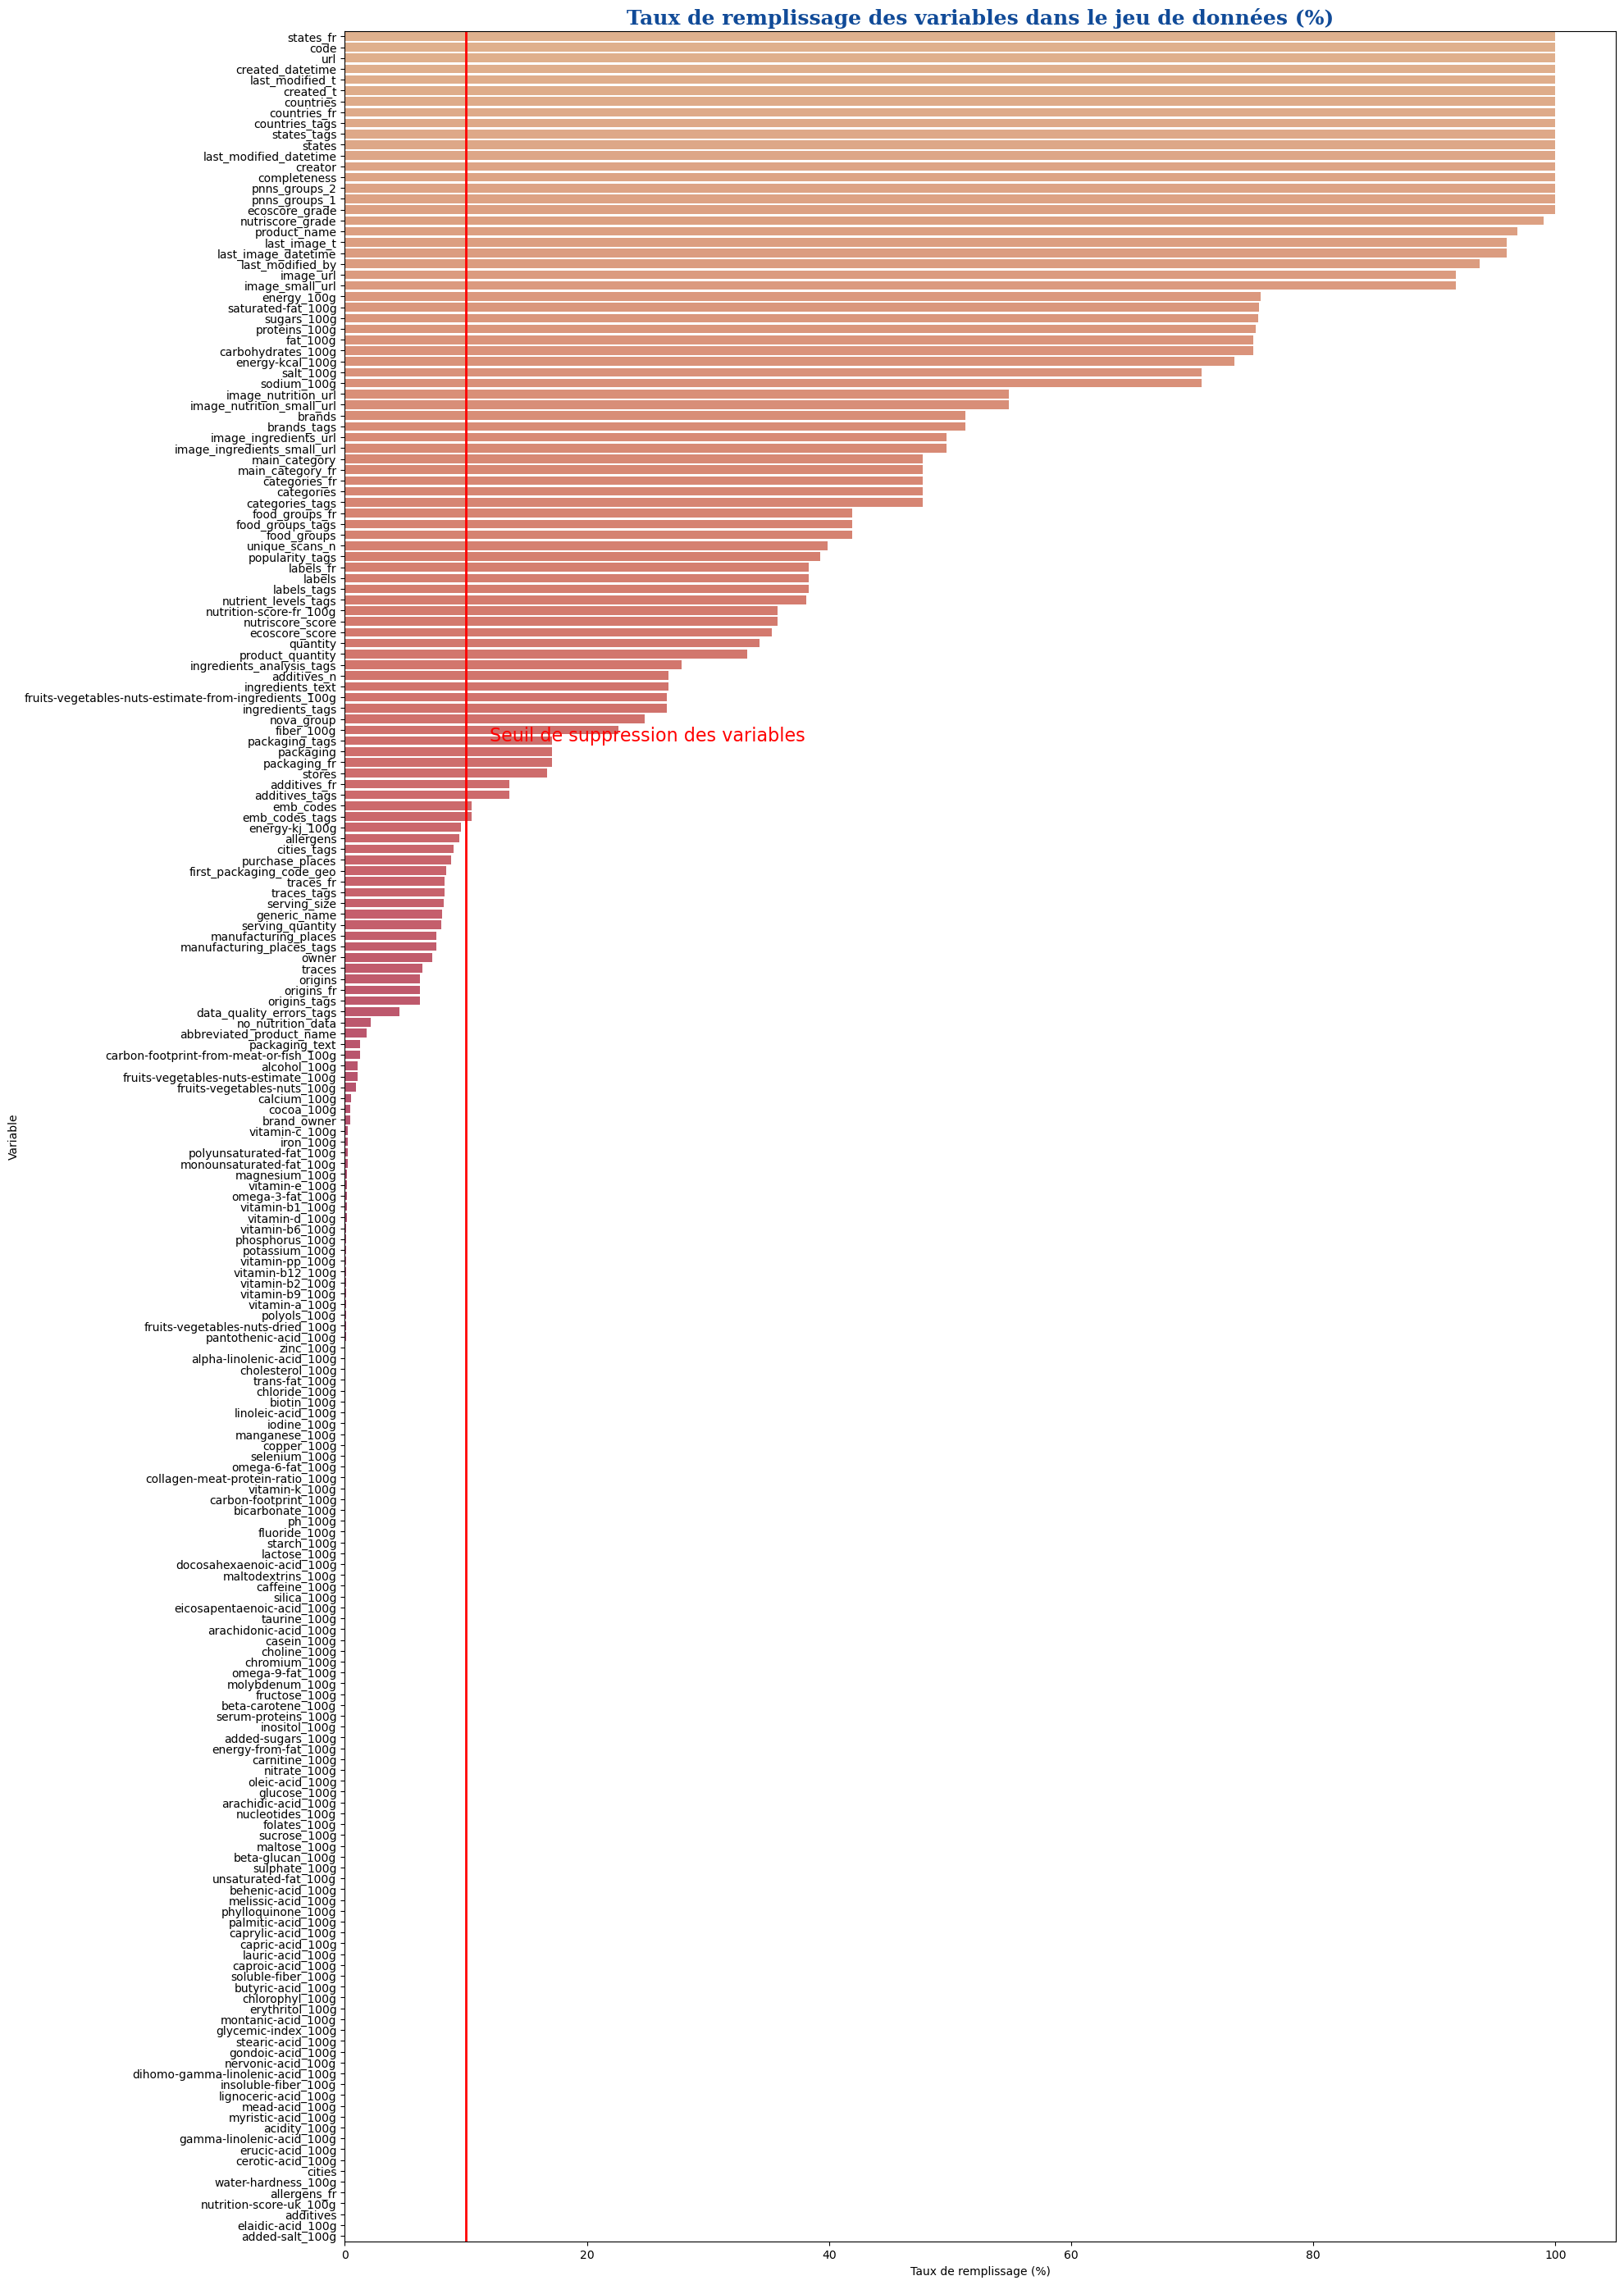

In [42]:
#On calcule le taux de remplissage de chaque variable
def null_factor(df):
  null_rate = ((df.isnull().sum() / df.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  return null_rate

#Nous alllons désormais commencer à nettoyer la base de données en enlevant les colonnes peu remplis. 
filling_features = null_factor(df_france)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 10

#On affiche le taux de remplissages des variables en fonction d'un seuil de référence
fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

On va supprimer les colonnes qui ne sont pas remplies à + de 10% 

In [43]:
#On ne décide de ne garder que les colonnes remplis à plus de 25%
seuil = 10  
filled_variables = list(filling_features.loc[filling_features['Taux_de_Null'] >= seuil, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
df_france = df_france[filled_variables]

# Affichage du résultat
print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

for column_name in df_france.columns:
    print(column_name)

Le dataframe df_france compte 924663 lignes et 73 variables
states_fr
code
url
created_datetime
last_modified_t
created_t
countries
countries_fr
countries_tags
states_tags
states
last_modified_datetime
creator
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
last_image_t
last_image_datetime
last_modified_by
image_url
image_small_url
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
salt_100g
sodium_100g
image_nutrition_url
image_nutrition_small_url
brands
brands_tags
image_ingredients_url
image_ingredients_small_url
main_category
main_category_fr
categories_fr
categories
categories_tags
food_groups_fr
food_groups_tags
food_groups
unique_scans_n
popularity_tags
labels_fr
labels
labels_tags
nutrient_levels_tags
nutrition-score-fr_100g
nutriscore_score
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g
i

On allège de nouveau la base de donnée en enlevant les variables qui ne nous intéresse pas pour la suite (celles qui contiennent des images des produits notamment par exemple et qui consomment beaucoup de place)

In [44]:
#On supprime les variables inutiles pour le reste du projet pour alléger la base
useless_columns = [col for col in df_france.columns if 'url' in col or 'image' in col or "categories" in col or "last" in col or "states" in col or "creator" in col ]
df_france = df_france.drop(columns=useless_columns)

print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))

#On affiche le nom des colonnes restantes
for column_name in df_france.columns:
    print(column_name)


Le dataframe df_france compte 924663 lignes et 54 variables
code
created_datetime
created_t
countries
countries_fr
countries_tags
completeness
pnns_groups_2
pnns_groups_1
ecoscore_grade
nutriscore_grade
product_name
energy_100g
saturated-fat_100g
sugars_100g
proteins_100g
fat_100g
carbohydrates_100g
energy-kcal_100g
salt_100g
sodium_100g
brands
brands_tags
main_category
main_category_fr
food_groups_fr
food_groups_tags
food_groups
unique_scans_n
popularity_tags
labels_fr
labels
labels_tags
nutrient_levels_tags
nutrition-score-fr_100g
nutriscore_score
ecoscore_score
quantity
product_quantity
ingredients_analysis_tags
additives_n
ingredients_text
fruits-vegetables-nuts-estimate-from-ingredients_100g
ingredients_tags
nova_group
fiber_100g
packaging_tags
packaging
packaging_fr
stores
additives_fr
additives_tags
emb_codes
emb_codes_tags


In [46]:
#On ne garde que les variables où les informations nutritionneles sont complétées  


df_france = df_france[(df_france['nutriscore_grade'].notnull()) & (df_france['ecoscore_grade'].notnull()) & (df_france['fiber_100g'].notnull()) & (df_france['energy_100g'].notnull()) & (df_france['saturated-fat_100g'].notnull())  & (df_france['sugars_100g'].notnull())  & (df_france['proteins_100g'].notnull()) & (df_france['fat_100g'].notnull()) & (df_france['salt_100g'].notnull()) & (df_france['carbohydrates_100g'].notnull()) & (df_france['sodium_100g'].notnull())]

print(df_france.describe())

print ("Le dataframe df_france compte {} lignes et {} variables".format(df_france.shape[0], df_france.shape[1]))


          created_t   completeness   energy_100g  saturated-fat_100g  \
count  1.889940e+05  188994.000000  1.889940e+05       188994.000000   
mean   1.552447e+09       0.640978  3.148248e+11            4.455840   
std    8.542597e+07       0.233137  1.368652e+14            7.183137   
min    1.328784e+09       0.100000  0.000000e+00            0.000000   
25%    1.498393e+09       0.475000  4.420000e+02            0.200000   
50%    1.524161e+09       0.675000  1.038000e+03            1.600000   
75%    1.637346e+09       0.800000  1.648000e+03            5.700000   
max    1.703662e+09       1.100000  5.950000e+16          100.000000   

         sugars_100g  proteins_100g       fat_100g  carbohydrates_100g  \
count  188994.000000  188994.000000  188994.000000        188994.00000   
mean       12.772050       8.239835      12.573708            28.90769   
std        18.416412       9.544789      16.478534            27.02713   
min         0.000000       0.000000       0.000000     

In [47]:
#On continue le nettoyage de la base en enlevant les valeurs abérrantes
#Open food fact est une base open source ouverte à tous. Il n'est pas abérrant de penser que des erreurs ont pu se produire lors  de l'entrée de certaines données

def suppression_aberrations(df):
    # Cette fonction supprime les observations où les valeurs sont aberrantes

    var_pour_100g = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']

    for var in var_pour_100g:
        df = df[(df[var] >= 0) & (df[var] <= 100)]

    return df


In [48]:
#On regarde combien d'observations étient abérrantes

ni=df_france.shape[0] 

# Appliquer la fonction sur le DataFrame
df_france = suppression_aberrations(df_france)

nf=df_france.shape[0]

delta_lignes=ni-nf #Controle du nombre de lignes supprimées 

print(delta_lignes,"lignes considérées comme des abérrations et donc supprimées")


30 lignes considérées comme des abérrations et donc supprimées


In [50]:
#Transformons le Nutriscore en variable quantitative, ce qui sera utile pour faire des régressions
def convertion_num_score(lettre):
    if lettre =="a":
        score=1
    elif lettre == "b":
        score=2
    elif lettre == "c":
        score=3
    elif lettre == "d":
        score=4
    elif lettre == "e":
        score=5
    else:
        score=np.nan
    return score

df_france["nutriscore (num)"]=df_france['nutriscore_grade'].apply(convertion_num_score)
df_france["ecoscore (num)"]=df_france['ecoscore_grade'].apply(convertion_num_score)

On réalise désormais des statistiques descriptives 
On commence par étudier le Nutriscore, qui est le principal score utilisé pour déterminer la qualitée nutritionnelles 

On commence par montrer la répartition du score du Nutriscore dans la base. 

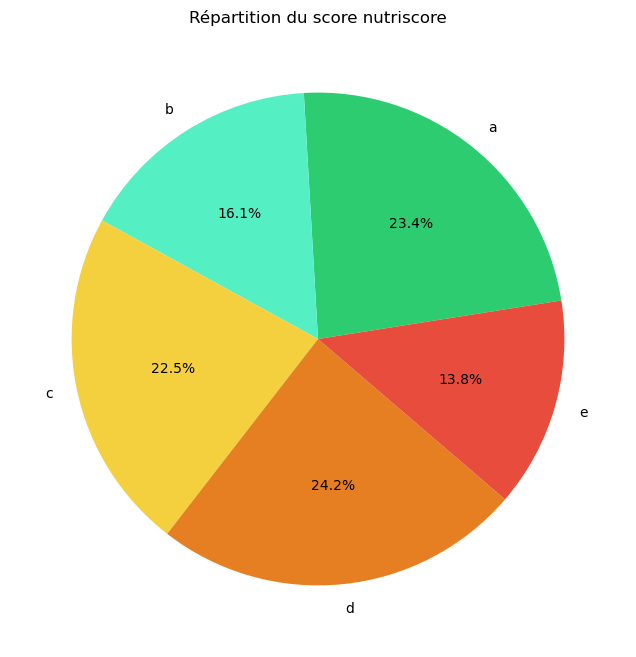

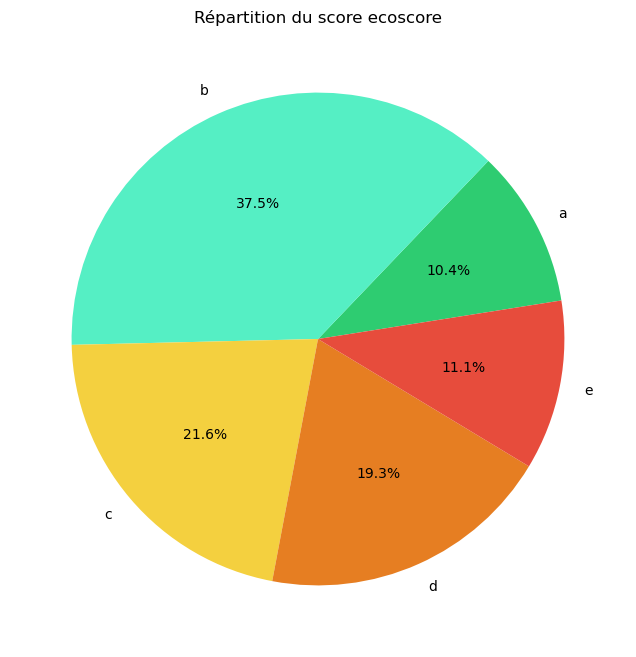

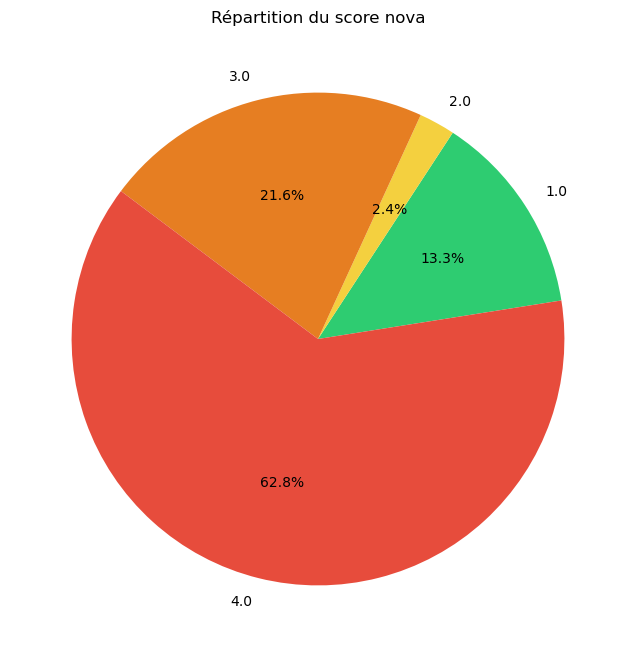

In [71]:

def plot_pie(score):
    # Filtrer les données pour exclure la catégorie 'Unknown' et 'non-applicable'

    filtered_data = df_france[(df_france[score] != 'unknown') & (df_france[score] != 'not-applicable')]

    # Compter les occurrences des valeurs dans la colonne 'nutriscore_grade' et trier par index (ordre alphabétique)
    score_counts = filtered_data[score].value_counts().sort_index()

    nutriscore_colors = {'a': '#2ecc71', 'b': '#55efc4', 'c': '#f4d03f', 'd': '#e67e22', 'e': '#e74c3c', '1.0': '#2ecc71', '2.0': '#f4d03f', '3.0': '#e67e22', '4.0': '#e74c3c'}
    colors = [nutriscore_colors.get(str(category), '#95a5a6') for category in score_counts.index]

    # Créer le diagramme circulaire avec les couleurs spécifiques du Nutri-Score
    plt.figure(figsize=(8, 8))
    plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=9, colors=colors)
    score_name = score.split("_")
    plt.title('Répartition du score ' + score_name[0])
    plt.show()


#On affiche les différentes scores
plot_pie("nutriscore_grade")
plot_pie("ecoscore_grade")
plot_pie("nova_group")

/tmp/ipykernel_32424/568082430.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['created_datetime'] = pd.to_datetime(filtered_data['created_datetime'])


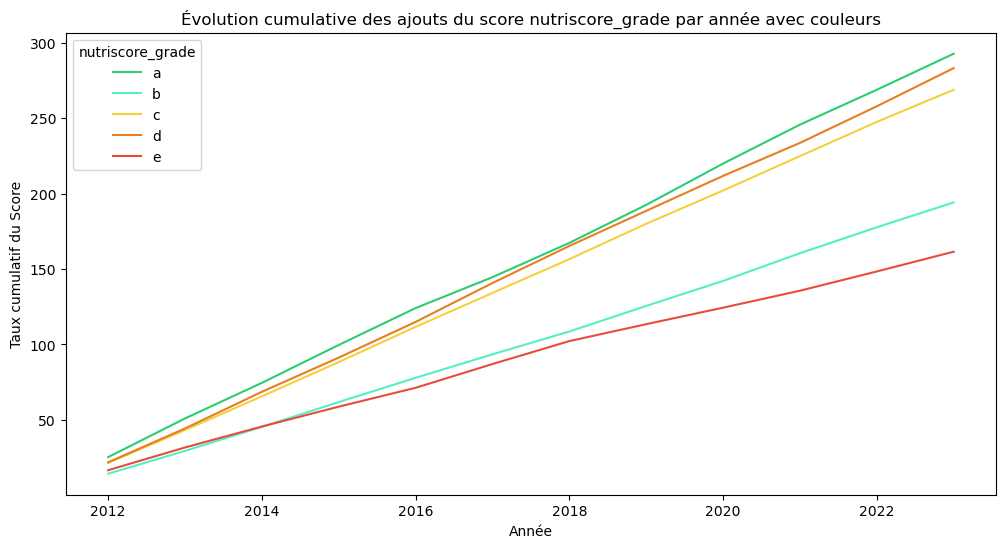

In [101]:
def plot_time_evolution(score):
    filtered_data = df_france[(df_france[score] != 'unknown') & (df_france[score] != 'not-applicable')]

    # Ensure 'created_datetime' is a datetime column
    filtered_data['created_datetime'] = pd.to_datetime(filtered_data['created_datetime'])

    # Group by score and year
    score_per_year = filtered_data[['code', score]].groupby(by=[score, filtered_data['created_datetime'].dt.year]).nunique().reset_index()

    # Calculate cumulative per year
    cum_per_year = filtered_data[['code']].groupby(by=filtered_data['created_datetime'].dt.year).nunique().reset_index()

    # Merge DataFrames
    score_per_year = pd.merge(score_per_year, cum_per_year, how="left", left_on="created_datetime", right_on="created_datetime")
    score_per_year = score_per_year.rename(columns={'created_datetime': 'year', 'code_x': 'nb_score', 'code_y': 'total_grade'})
    score_per_year['score_rate'] = (score_per_year['nb_score'] / score_per_year['total_grade']) * 100

    # Calculate cumulative sum for each score
    score_per_year['cumulative_score_rate'] = score_per_year.groupby(score)['score_rate'].cumsum()

    # Plotting
    fig, axes = plt.subplots(figsize=(12, 6))
    nutriscore_colors = {'a': '#2ecc71', 'b': '#55efc4', 'c': '#f4d03f', 'd': '#e67e22', 'e': '#e74c3c', '1.0': '#2ecc71', '2.0': '#f4d03f', '3.0': '#e67e22', '4.0': '#e74c3c'}

    # Cumulative Line Plot
    sns.histplot(x='year', y='cumulative_score_rate', hue=score, data=score_per_year, palette=nutriscore_colors)
    plt.xlabel("Année")
    plt.ylabel("Taux cumulatif du Score")
    plt.title(f"Évolution cumulative des ajouts du score {score} par année avec couleurs")
    plt.legend(title=score)
    plt.show

plot_time_evolution("nutriscore_grade")


In [77]:
#On affiche l'évolution temporel de la répartition temporel des scores

def plot_time_evolution(score):
    filtered_data = df_france[(df_france[score].isnull()==False) & 
                    (df_france[score].isnull()==False)]

    score_per_year = filtered_data[['code',score]].groupby(by=[score,filtered_data['created_datetime'].dt.year]).nunique().reset_index()
    cum_per_year = filtered_data[['code']].groupby(by=filtered_data['created_datetime'].dt.year).nunique().reset_index()
    score_per_year = pd.merge(ng_per_year, cum_per_year, how="left", left_on="created_datetime", right_on="created_datetime")
    score_per_year = ng_per_year.rename(columns={'created_datetime':'year', 'code_x':'nb_score', 'code_y':'total_grade'})
    score_per_year['score_rate'] = (ng_per_year['nb_score'] / ng_per_year['total_grade'])*100

    fig =plt.figure(figsize=(12,8))
    ax = sns.lineplot(x='year', y='nutrigrade_rate', hue='nutriscore_grade', data=ng_per_year)
    plt.xlabel("Année")
    plt.ylabel("Taux du Nutrigrade")
    plt.title("Evolution de la répartition des Nutrigrades au fil des années", fontdict=font_title)

    plt.show()


plot_time_evolution("nutriscore_grade")

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
#Une moyenne lissée permet de mieux voir les tendances

In [ ]:
#On affiche le score brut du nutriscore, avant transformation en grade

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle("Répartition des scores Nutriscore et de leurs grades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=df_france.sort_values("nutriscore_grade"), x="nutriscore_score", hue="nutriscore_grade", ax=axes[1])
axes[1].set_title('Scores de Nutriscores')
axes[1].set_xlabel("Score Nutriscore")
axes[1].set_ylabel("Nombre de produits")

plt.show()

In [ ]:
II. Partie analyse

A partir de cette liste, en modifiant à la main, on va garder uniquement les variables que je souhaite étudier pour la suite. 

On va désormais élargir notre analyse en prenant en compte de nouveaux critères qui sont importants lorsqu'on souhaite mieux s'alimenter: le degré de transformation, les additifs et la provenance des produits. On va essayer de créé des variables de scoring pour ces trois catégories avant de faire une comparaison avec le Nutri-Score étudié au dessus. 

1. Analyse du degré de transformation

Pour cette variable, le principal problème est la quantification de la transformation du produit alimentaire. Une approche simple serait de considérer que plus un produit alimentaire contient d'ingrédient, plus il est transformé. 


In [ ]:
# Afficher les valeurs uniques de la colonne 'main_category_fr'
valeurs_main_category_fr = df_france['food_groups_tags'].unique()

# Afficher les valeurs
print(valeurs_main_category_fr)


['en:fruits-and-vegetables,en:vegetables'
 'en:milk-and-dairy-products,en:dairy-desserts' nan
 'en:fats-and-sauces,en:dressings-and-sauces'
 'en:beverages,en:fruit-juices' 'en:sugary-snacks,en:sweets'
 'en:composite-foods,en:one-dish-meals'
 'en:composite-foods,en:pizza-pies-and-quiches'
 'en:fruits-and-vegetables,en:fruits'
 'en:fish-meat-eggs,en:meat,en:poultry'
 'en:beverages,en:sweetened-beverages'
 'en:milk-and-dairy-products,en:cheese' 'en:cereals-and-potatoes,en:bread'
 'en:fish-meat-eggs,en:fish-and-seafood,en:fatty-fish'
 'en:cereals-and-potatoes,en:legumes'
 'en:fish-meat-eggs,en:meat,en:meat-other-than-poultry'
 'en:sugary-snacks,en:biscuits-and-cakes'
 'en:salty-snacks,en:salty-and-fatty-products'
 'en:fruits-and-vegetables,en:dried-fruits' 'en:fats-and-sauces,en:fats'
 'en:cereals-and-potatoes' 'en:beverages,en:unsweetened-beverages'
 'en:cereals-and-potatoes,en:cereals' 'en:alcoholic-beverages'
 'en:salty-snacks,en:nuts' 'en:salty-snacks,en:appetizers'
 'en:sugary-snacks,